#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


## Homework 3:Deep Reinforcement Learning

**General overview**: In this homework you will learn how to implement and test neural network models for
solving reinforcement learning problems. The basic tasks for the homework will require to implement some
extensions to the code that you have seen in the Lab. The advanced tasks will require to train and test your
learning agent on a different type of input (image pixels) or Gym environment. You can just choose one of
the advanced tasks to get the maximum grade. If you are interested in improving your skills, feel free to try
both advanced tasks. Given the higher computational complexity of RL, in this homework you don’t need to
tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged
to play with model hyperparameters to find a satisfactory configuration.

**Technical notes**: The homework should be implemented in Python using the PyTorch framework. The
student can explore additional libraries and tools to implement the models; however, please make sure you
understand the code you are writing because during the exam you might receive specific questions related
to your implementation. The entire source code required to run the homework must be uploaded as a
compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included
in a single Python notebook, just upload the notebook file.

**Final report**: Along with the source code, you must separately upload a PDF file containing a brief report of
your homework. The report should include a brief Introduction on which you explain the homework goals
and the main implementation strategies you choose, a brief Method section where you describe your
model architectures and hyperparameters, and a Result section where you present the simulation results.
Total length must not exceed 6 pages, though you can include additional tables and figures in a final
Appendix (optional). The report must be self-contained, so please make sure that all relevant results are
explicitly included in the report / notebook. Given the dynamical nature of RL problems, you can explore
more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).
Grade: The maximum grade for this homework will be 8 points. Points will be assigned based on the correct
implementation of the following items:

• 3 pt: use the notebook of Lab 07 to study how the exploration profile (either using eps-greedy or
softmax) impacts the learning curve. Tune a bit the model hyperparameters or tweak the reward
function to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).

• 5 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using
directly the screen pixels, rather than the compact state representation used during the Lab (cart
position, cart velocity, pole angle, pole angular velocity). NB: this will require to change the
“observation_space” and to look for smart ways of encoding the pixels in a compact way to reduce
computational complexity (e.g., crop the image around the pole, use difference of consecutive frames
as input to consider temporal context, etc.).
or

• 5 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym
environment you like from the available list, or even explore other simulation platforms.

In [1]:
!pip install gym

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # TODO: Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [9]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(5, 5, 5, 5), (4, 4, 4, 4)]


# Policy network

## Network definition

In [10]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)

                )

    def forward(self, x):
        return self.linear(x)

In [11]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [12]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [13]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [ 0.12682928 -0.00197712]


### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [14]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [15]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [ 0.12682928 -0.00197712]


### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

In [16]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 2) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
first_exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

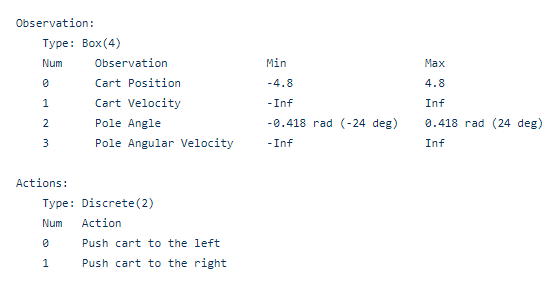

In [17]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [18]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [19]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [20]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop (first version)
Reward is not updated

In [21]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_list_e_p = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

for episode_num, tau in enumerate(tqdm(first_exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += 1

      #Compute new reward
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    #Save the score
    score_list_e_p.append(score)
    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.983931496009206
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.967914631382513
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.951949240166455
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.93603515694089
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.9201722168172894
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.904360255437025
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.888599108969669
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.872888614111296
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.857228608082787
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.841618928628152
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.826059414012839
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.810549903022064
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.79509023495914
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.779680249643809
EPISODE: 16 - FINAL SCORE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 44 - FINAL SCORE: 35 - Temperature: 4.3537008432473865
EPISODE: 45 - FINAL SCORE: 18 - Temperature: 4.339709351372498
EPISODE: 46 - FINAL SCORE: 23 - Temperature: 4.325762823966215
EPISODE: 47 - FINAL SCORE: 20 - Temperature: 4.31186111652619
EPISODE: 48 - FINAL SCORE: 16 - Temperature: 4.29800408501446
EPISODE: 49 - FINAL SCORE: 26 - Temperature: 4.284191585855959
EPISODE: 50 - FINAL SCORE: 14 - Temperature: 4.270423475937029
Updating target network...
EPISODE: 51 - FINAL SCORE: 52 - Temperature: 4.256699612603935
EPISODE: 52 - FINAL SCORE: 17 - Temperature: 4.243019853661387
EPISODE: 53 - FINAL SCORE: 37 - Temperature: 4.229384057371072
EPISODE: 54 - FINAL SCORE: 14 - Temperature: 4.215792082450179
EPISODE: 55 - FINAL SCORE: 18 - Temperature: 4.2022437880699375
EPISODE: 56 - FINAL SCORE: 43 - Temperature: 4.1887390338541595
EPISODE: 57 - FINAL SCORE: 20 - Temperature: 4.175277679877784
EPISODE: 58 - FINAL SCORE: 17 - Temperature: 4.161859586665426
EPISODE: 59 - FINAL SCORE: 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

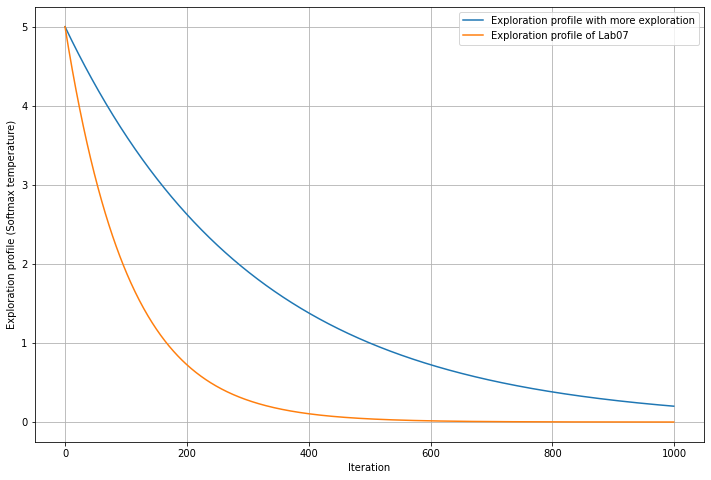

In [22]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(first_exploration_profile, label = 'Exploration profile with more exploration')
plt.plot(exploration_profile, label = 'Exploration profile of Lab07')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [23]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [24]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_list_f_v = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      #Compute new reward
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    #Save the score
    score_list_f_v.append(score)
    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 15 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 15 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 20 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 10 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 11 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 32 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 13 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 29 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 16 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 20 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 9 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 18 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 25 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 16 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCOR

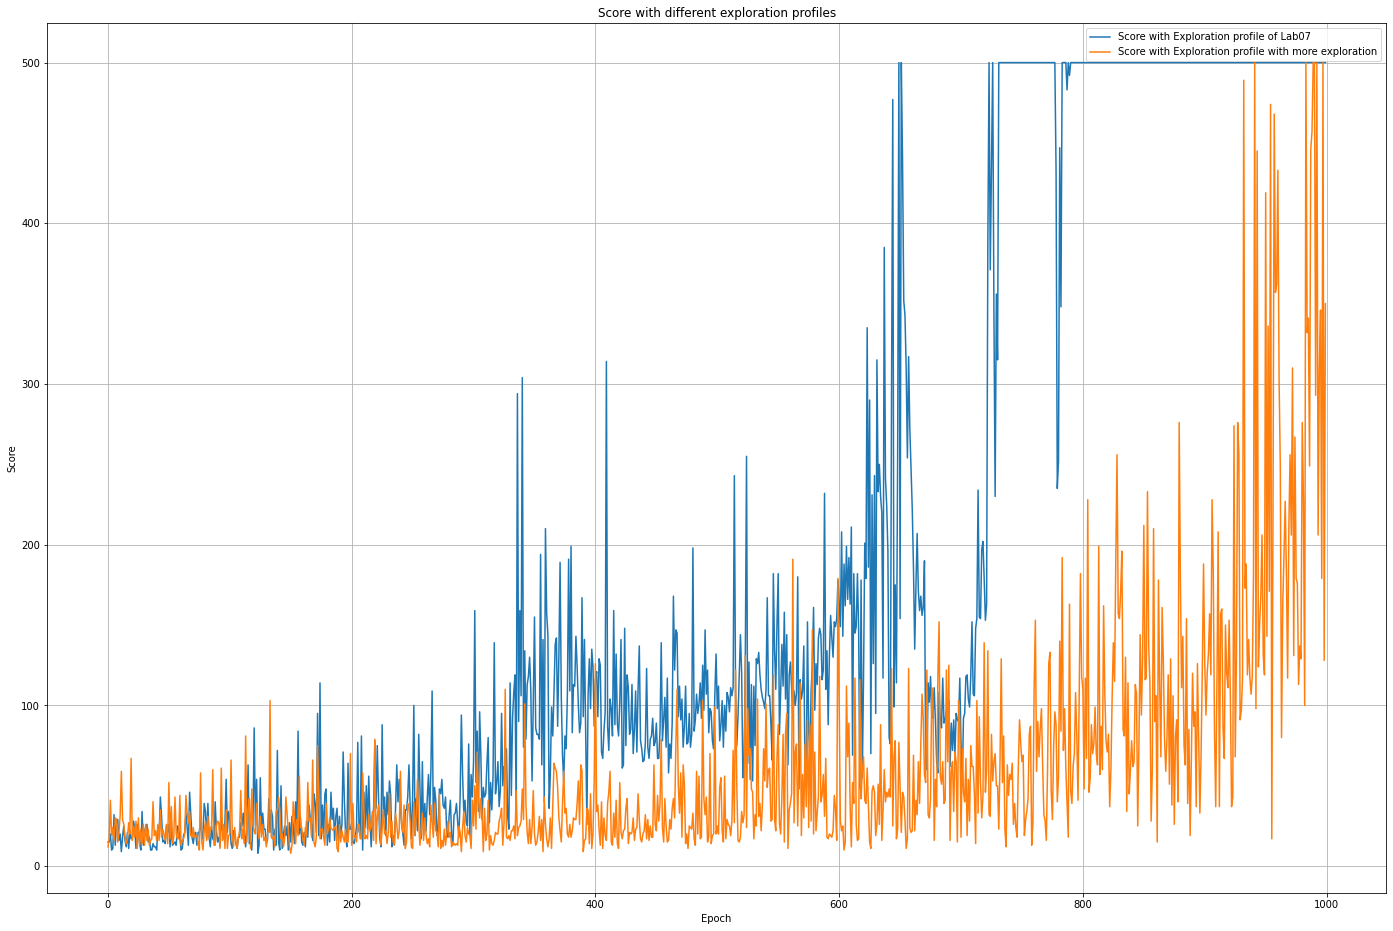

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot losses of train and validation
plt.figure(figsize=(24,16))
plt.plot(score_list_f_v, label='Score with Exploration profile of Lab07')
plt.plot(score_list_e_p, label='Score with Exploration profile with more exploration')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid()
plt.title('Score with different exploration profiles')
plt.legend()
plt.show()
plt.savefig('loss_plot_Standard.png', bbox_inches='tight')

In [26]:
# Display the videos, not required outside Colab
#show_videos()

## Training loop (advanced)
Let's modify the reward to improve the results.

In [27]:
torch.manual_seed(0)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [28]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
score_list_normed_angle = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    alpha = 10
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)


      pos_weight = 1
      # We apply a (linear) penalty when the cart is far from center
      reward =  reward + - pos_weight * np.abs(state[0]) - alpha*(abs(next_state[2]))

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    #Save the score
    score_list_normed_angle.append(score)

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 33 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 31 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 19 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 17 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 14 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 19 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 20 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 14 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 60 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 10 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 16 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 31 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 32 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

In [29]:
torch.manual_seed(0)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [30]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

max_position = 4.8
max_angle = 0.418

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
score_list_normalized_v = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    alpha = 100
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      #We give a reward taking care about the angle displacement from the equilibrium and the displacement
      #of the box from the center
      reward = reward - (abs(state[0]/max_position) + abs(state[2]/max_angle))
      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    #Save the score
    score_list_normalized_v.append(score)

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 47 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 22 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 12 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 16 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 18 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 23 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 40 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 14 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 22 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 12 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 15 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 13 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 10 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 11 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

In [31]:
# Display the videos, not required outside Colab
#show_videos()

In [32]:
torch.manual_seed(0)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [33]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
score_list_l_v = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    alpha = 100
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      #We give a reward taking care about the angle displacement from the equilibrium and the displacement
      #of the box from the center
      reward = -alpha*(abs(next_state[2])-abs(state[2]))
      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    #Save the score
    score_list_l_v.append(score)

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 19 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 14 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 46 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 29 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 19 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 18 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 16 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 18 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 28 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 19 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 28 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 9 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 32 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCORE

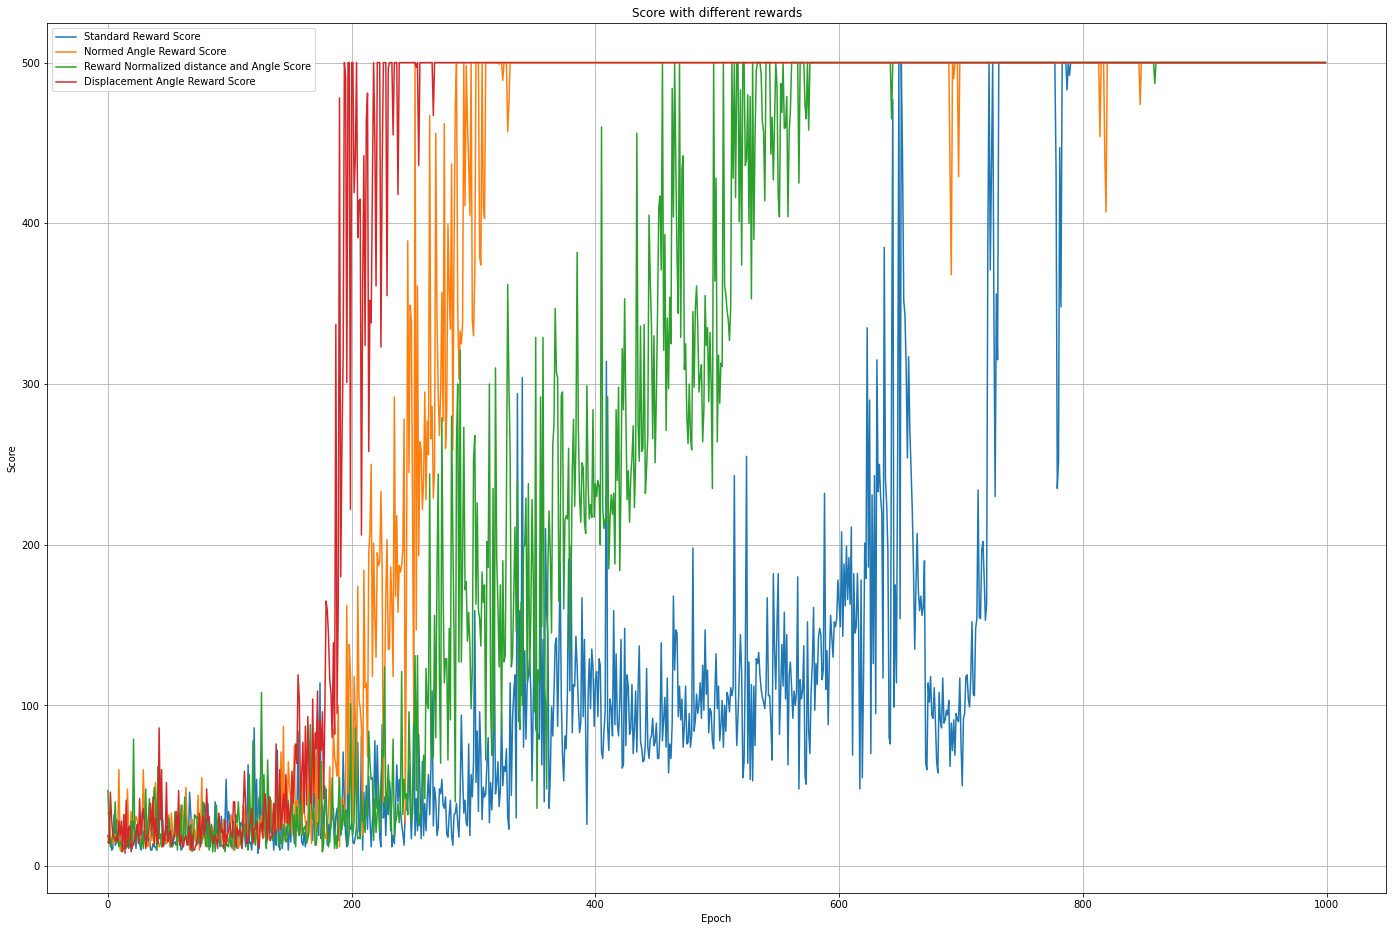

<Figure size 432x288 with 0 Axes>

In [34]:
# Plot losses of train and validation
plt.figure(figsize=(24,16))
plt.plot(score_list_f_v, label='Standard Reward Score')
plt.plot(score_list_normed_angle, label='Normed Angle Reward Score')
plt.plot(score_list_normalized_v, label='Reward Normalized distance and Angle Score')
plt.plot(score_list_l_v, label='Displacement Angle Reward Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid()
plt.title('Score with different rewards')
plt.legend()
plt.show()
plt.savefig('loss_plot_Standard.png', bbox_inches='tight')

# Final test

In [35]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [36]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.5.69.video000000.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000001.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000002.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000003.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000004.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000005.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000006.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000007.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000008.mp4



SHOWING VIDEO video/openaigym.video.5.69.video000009.mp4


# Homework part 2

## Mountain Car Environment

Actions (3-dim):
0. Push Left
1. No Push
2. Push Right

State (2-dim):
0. Position from -1.2 to 0.6
1. Velocity from -0.07 to 0.07

Reward:
-1 for each time step, until the goal position of 0.5 is reached.


In [37]:
!apt install gym

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package gym


In [38]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [783 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,563 kB]
Hit:1

In [39]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeoryimport glob

In [40]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [41]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [42]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [43]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [44]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # TODO: Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)

                )

    def forward(self, x):
        return self.linear(x)

In [45]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

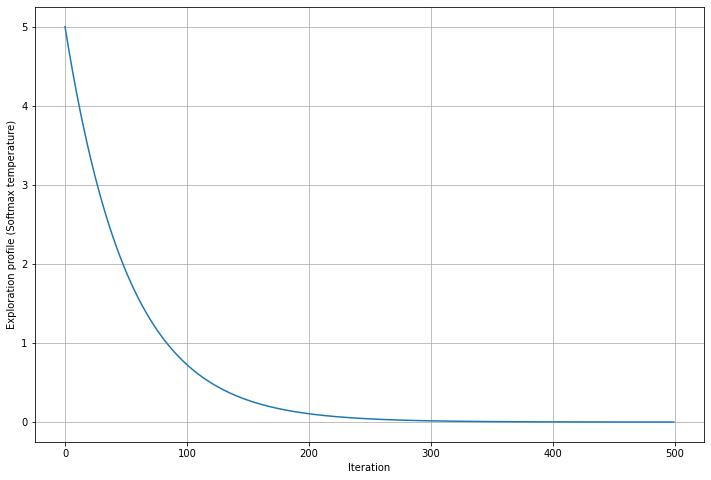

In [46]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Define exploration profile
initial_value = 5
num_iterations = 500
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [47]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [48]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


In [49]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [50]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Training the agent

In [51]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_list_f_v = []
max_iter = 200

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    iteration = 0
    done = False
    total_reward = 0

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      
      #Compute score
      score = state[0]

      if (action ==0 and state[1]<0) or (action==2 and state[1]>0):
            reward= reward + 6 * np.abs(state[0]+0.5)
      elif (next_state[0]<state[0] and action == 0 and state[0] > 0) or (next_state[0]>state[0] and action == 2 and state[0] < 0):
            reward= reward + 3 * np.abs(state[0]+0.5)
      else:
            reward -= 2
      if(state[0]>0.485):
        reward += 100

      total_reward += reward

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    #Save the score
    score_list_f_v.append(score)
    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - Reward: {total_reward}") # Print the final score

env.close()

  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -0.46158377387638805 - Temperature: 5.0 - Reward: -426.0787879713011
EPISODE: 2 - FINAL SCORE: -0.5427428986061521 - Temperature: 4.904360255437023 - Reward: -436.03738271274074
EPISODE: 3 - FINAL SCORE: -0.5302125688191489 - Temperature: 4.8105499030220615 - Reward: -419.9669754284821
EPISODE: 4 - FINAL SCORE: -0.5015577286964845 - Temperature: 4.718533950235565 - Reward: -443.09432439382596
EPISODE: 5 - FINAL SCORE: -0.47544349604726566 - Temperature: 4.628278073893113 - Reward: -448.3377154913126
EPISODE: 6 - FINAL SCORE: -0.39687869471496523 - Temperature: 4.539748607342401 - Reward: -425.42488219667894
EPISODE: 7 - FINAL SCORE: -0.6311116865649846 - Temperature: 4.45291252790513 - Reward: -406.0603377533808
EPISODE: 8 - FINAL SCORE: -0.645093300120974 - Temperature: 4.367737444559105 - Reward: -363.4832619487001
EPISODE: 9 - FINAL SCORE: -0.5102336936124278 - Temperature: 4.2841915858559485 - Reward: -389.4811147100811
EPISODE: 

In [52]:
# Display the videos, not required outside Colab
#show_videos()

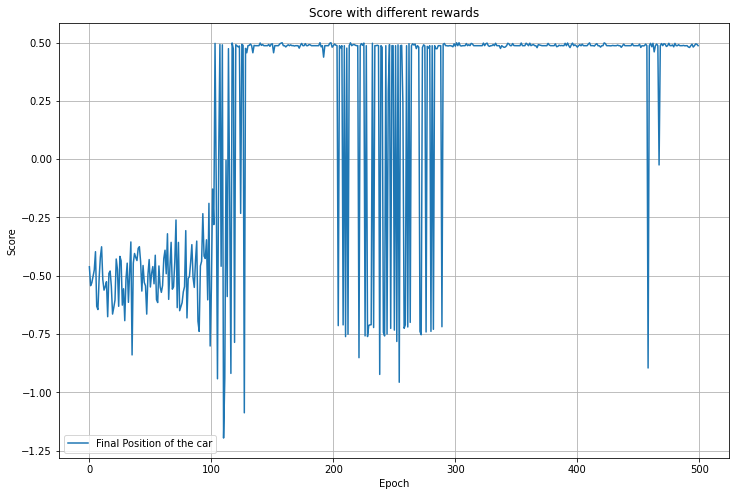

<Figure size 432x288 with 0 Axes>

In [53]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.plot(score_list_f_v, label='Final Position of the car')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid()
plt.title('Score with different rewards')
plt.legend()
plt.show()
plt.savefig('loss_plot_Standard.png', bbox_inches='tight')

## Test the agent

In [54]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score = next_state[0]
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
        # Visually render the environment (disable to speed up the training)
        env.render()
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 0.5042786500575005
EPISODE 2 - FINAL SCORE: 0.5368577983788596
EPISODE 3 - FINAL SCORE: 0.5368577983788596
EPISODE 4 - FINAL SCORE: 0.5368577983788596
EPISODE 5 - FINAL SCORE: 0.5116746297526136
EPISODE 6 - FINAL SCORE: 0.5368577983788596
EPISODE 7 - FINAL SCORE: 0.5368577983788596
EPISODE 8 - FINAL SCORE: 0.5368577983788596
EPISODE 9 - FINAL SCORE: 0.5145911802342709
EPISODE 10 - FINAL SCORE: 0.5368577983788596
